# IBM Capstone Project: The Battle of Neighborhoods

## "Recommending prime housing locations"

### Business Problem

Land is a precious resource in Singapore, naturally, purchasing a home in the country is an important financial commitment. In this report, we will be taking up the hypothetical scenario as a local real estate agency that seeks to help middle-income buyers seek out prime housing locations in Singapore based on their preferences. Thus, the main objective of this project is to provide different housing location options based on different HDB types of residential clusters generated.

---

## 1.1 Import Relevant Libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


----

## 1.2 Preparing Resale Flat Prices on Data.gov.sg

In [3]:
# HDB Resale Flat data API
url = 'https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&limit=103087'
url

'https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&limit=103087'

In [4]:
# Get Data from API
results = requests.get(url).json()

In [5]:
# Create Dataframe to store results that we will be using
hdb_resale_results = results['result']['records']
hdb_resale = json_normalize(hdb_resale_results)

#We will be using Town names, addresses, resale prices, size of flat, and remaining leasesz
filtered_columns = ['town', 'street_name', 'block', 'resale_price', 'floor_area_sqm', 'remaining_lease']
hdb_resale =hdb_resale.loc[:, filtered_columns]

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


In [6]:
#Data processing
hdb_resale[['remaining_lease_years', 'e']] = hdb_resale['remaining_lease'].str.split('y', 1, expand=True)
hdb_resale['address'] = hdb_resale['block'].map(str) + ' ' + hdb_resale['street_name'].map(str)
hdb_resale.drop(['street_name', 'block', 'e', 'remaining_lease'], axis=1, inplace=True)
hdb_resale = hdb_resale[['town', 'address', 'resale_price', 'floor_area_sqm', 'remaining_lease_years']]

hdb_resale['resale_price'] = pd.to_numeric(hdb_resale.resale_price) 
hdb_resale['floor_area_sqm'] = pd.to_numeric(hdb_resale.floor_area_sqm) 
hdb_resale['remaining_lease_years'] = pd.to_numeric(hdb_resale.remaining_lease_years)

hdb_resale.head()

,town,address,resale_price,floor_area_sqm,remaining_lease_years
0,ANG MO KIO,406 ANG MO KIO AVE 10,232000.0,44.0,61
1,ANG MO KIO,108 ANG MO KIO AVE 4,250000.0,67.0,60
2,ANG MO KIO,602 ANG MO KIO AVE 5,262000.0,67.0,62
3,ANG MO KIO,465 ANG MO KIO AVE 10,265000.0,68.0,62
4,ANG MO KIO,601 ANG MO KIO AVE 5,265000.0,67.0,62


In [8]:
#Data processing: Taking a sample of 500 flats in towns located in the East of Singapore for this exercise
hdb_east1 = hdb_resale[hdb_resale['town'].str.contains("BEDOK")]
hdb_east2 = hdb_resale[hdb_resale['town'].str.contains("TAMPINES")]
hdb_east3 = hdb_resale[hdb_resale['town'].str.contains("PASIR RIS")]

frames = [hdb_east1, hdb_east2, hdb_east3]
hdb_east = pd.concat(frames)
hdb_east = hdb_east.sample(n=500, random_state=1).reset_index(drop=True)

----

## 1.3 Preparing OneMap API to obtain the geo-coordinates

In [9]:
# List of addresses
list_of_address = hdb_east['address'].tolist()
add_lat = []
add_long = []

In [10]:
# Obtaining coordinates for 500 addresses

for i in range(0, len(list_of_address)):
    query_address = list_of_address[i]
    query_string = 'https://developers.onemap.sg/commonapi/search?searchVal='+str(query_address)+'&returnGeom=Y&getAddrDetails=Y'
    resp = requests.get(query_string)

    data_add=json.loads(resp.content)
    
    if data_add['found'] != 0:
        add_lat.append(data_add["results"][0]["LATITUDE"])
        add_long.append(data_add["results"][0]["LONGITUDE"])

    else:
        add_lat.append('NotFound')
        add_long.append('NotFound')

In [11]:
# Store this information in a dataframe

hdb_east['Latitude'] = add_lat
hdb_east['Longitude'] = add_long
hdb_east.head(3)

,town,address,resale_price,floor_area_sqm,remaining_lease_years,Latitude,Longitude
0,TAMPINES,278 TAMPINES ST 22,470000.0,132.0,63,1.34678375050017,103.951136569321
1,TAMPINES,308 TAMPINES ST 32,630000.0,142.0,71,1.35286747357104,103.95673502603
2,TAMPINES,856F TAMPINES ST 82,800000.0,147.0,74,1.35291277412563,103.938357435494


In [12]:
#Data Processing to rename columns for future use
hdb_east_for_clustering = hdb_east
hdb_grouped_clustering = hdb_east_for_clustering.drop(columns=['town', 'Latitude', 'Longitude'])
hdb_east_for_clustering.rename(columns={"address": "Neighborhood"}, inplace=True)
hdb_grouped_clustering.rename(columns={"address": "Neighborhood"}, inplace=True)

In [13]:
#Normalising numerics for better model training later
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

hdb_grouped_clustering['resale_price'] = scaler.fit_transform(hdb_grouped_clustering['resale_price'].values.reshape(-1,1))
hdb_grouped_clustering['floor_area_sqm'] = scaler.fit_transform(hdb_grouped_clustering['floor_area_sqm'].values.reshape(-1,1))
hdb_grouped_clustering['remaining_lease_years'] = scaler.fit_transform(hdb_grouped_clustering['remaining_lease_years'].values.reshape(-1,1))

In [14]:
hdb_grouped_clustering.head()

,Neighborhood,resale_price,floor_area_sqm,remaining_lease_years
0,278 TAMPINES ST 22,0.373239,0.778761,0.238095
1,308 TAMPINES ST 32,0.598592,0.867257,0.428571
2,856F TAMPINES ST 82,0.838028,0.911504,0.500000
3,139 BEDOK NTH AVE 3,0.478873,0.646018,0.166667
4,156 TAMPINES ST 12,0.711268,0.938053,0.261905


----

## 1.4 Foursquare API to explore common venues

In [15]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 20

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=150):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
# Get top 20 venues for every HDB address in a 150m radius

hdb_venues = getNearbyVenues(names=hdb_east['Neighborhood'],
                                   latitudes=hdb_east['Latitude'],
                                   longitudes=hdb_east['Longitude']
                                  )

In [18]:
hdb_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,278 TAMPINES ST 22,1.34678375050017,103.951136569321,Jin Biao Coffeeshop,1.347987,103.951742,Coffee Shop
1,278 TAMPINES ST 22,1.34678375050017,103.951136569321,280 Coffee Shop Tampines Street 22,1.347814,103.951741,Coffee Shop
2,278 TAMPINES ST 22,1.34678375050017,103.951136569321,Alvin's Western Food,1.347849,103.951882,Coffee Shop
3,278 TAMPINES ST 22,1.34678375050017,103.951136569321,The Best Prata Corner,1.347065,103.951078,Coffee Shop
4,278 TAMPINES ST 22,1.34678375050017,103.951136569321,Gerai Janda Sedap™,1.346399,103.950738,Australian Restaurant


----

## 2.1 Onehot Encoding

In [19]:
print('There are {} uniques categories.'.format(len(hdb_venues['Venue Category'].unique())))

There are 132 uniques categories.


In [20]:
# one hot encoding
hdb_venues_onehot = pd.get_dummies(hdb_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hdb_venues_onehot['Neighborhood'] = hdb_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hdb_venues_onehot.columns[-1]] + list(hdb_venues_onehot.columns[:-1])
hdb_venues_onehot = hdb_venues_onehot[fixed_columns]

hdb_venues_onehot.head(3)

,Neighborhood,Accessories Store,American Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Basketball Court,Bed & Breakfast,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Candy Store,Casino,Chinese Restaurant,Clothing Store,Coffee Shop,College Cafeteria,College Lab,Comfort Food Restaurant,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Event Space,Farm,Fast Food Restaurant,Field,Fishing Store,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gay Bar,General Entertainment,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,High School,Hotel Pool,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Malay Restaurant,Market,Martial Arts School,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Moving Target,Nightclub,Noodle House,Other Great Outdoors,Outdoors & Recreation,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Recreation Center,Restaurant,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soup Place,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trail,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio
0,278 TAMPINES ST 22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,278 TAMPINES ST 22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,278 TAMPINES ST 22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
hdb_venues_grouped = hdb_venues_onehot.groupby('Neighborhood').mean().reset_index()
hdb_venues_grouped.head()

,Neighborhood,Accessories Store,American Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Basketball Court,Bed & Breakfast,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Candy Store,Casino,Chinese Restaurant,Clothing Store,Coffee Shop,College Cafeteria,College Lab,Comfort Food Restaurant,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Event Space,Farm,Fast Food Restaurant,Field,Fishing Store,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gay Bar,General Entertainment,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,High School,Hotel Pool,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Malay Restaurant,Market,Martial Arts School,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Moving Target,Nightclub,Noodle House,Other Great Outdoors,Outdoors & Recreation,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Recreation Center,Restaurant,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soup Place,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trail,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio
0,1 BEDOK STH AVE 1,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.0,0.222222,0.0,0.000,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
1,101 PASIR RIS ST 12,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.200000,0.000000,0.00,0.0,0.0,0.200000,0.0,0.000,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
2,106 PASIR RIS ST 12,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.125000,0.125000,0.00,0.0,0.0,0.125000,0.0,0.125,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0
3,106 SIMEI ST 1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.333333,0.00,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.00

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = hdb_venues_grouped['Neighborhood']

for ind in np.arange(hdb_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hdb_venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1 BEDOK STH AVE 1,Noodle House,Chinese Restaurant,Food Court,Bubble Tea Shop,Asian Restaurant
1,101 PASIR RIS ST 12,Chinese Restaurant,Bus Station,Convenience Store,General Entertainment,Supermarket
2,106 PASIR RIS ST 12,Wings Joint,General Entertainment,Coffee Shop,Chinese Restaurant,Bus Stop
3,106 SIMEI ST 1,Bus Station,Bus Stop,Basketball Court,Yoga Studio,Field
4,107 BEDOK NTH RD,Chinese Restaurant,Café,Grocery Store,Food & Drink Shop,Yoga Studio


----

## 2.2 K-Means Clustering

In [25]:
hdb_grouped_clustering = pd.merge(hdb_grouped_clustering, hdb_venues_grouped, on="Neighborhood")

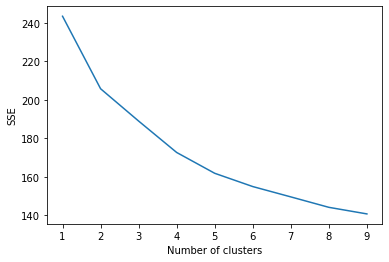

In [33]:
#Check for optimal cluster size using the elbow method
sse = {}
for k in range(1,10):
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(hdb_grouped_clustering_set)
    hdb_grouped_clustering['Cluster Labels'] = kmeans.labels_
    sse[k] = kmeans.inertia_

import matplotlib.pyplot as plt
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

In [34]:
# set number of clusters
kclusters = 5

hdb_grouped_clustering_set = hdb_grouped_clustering.drop('Neighborhood', 1)
hdb_grouped_clustering.drop(['Cluster Labels'], axis=1, inplace=True)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hdb_grouped_clustering_set)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 1, 1, 1, 4, 4, 1, 2, 1, 2], dtype=int32)

In [35]:
# add clustering labels
hdb_grouped_clustering.insert(0, 'Cluster Labels', kmeans.labels_)
hdb_grouped_clustering.head(1)

,Cluster Labels,Neighborhood,resale_price,floor_area_sqm,remaining_lease_years,Accessories Store,American Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Basketball Court,Bed & Breakfast,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Candy Store,Casino,Chinese Restaurant,Clothing Store,Coffee Shop,College Cafeteria,College Lab,Comfort Food Restaurant,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Event Space,Farm,Fast Food Restaurant,Field,Fishing Store,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gay Bar,General Entertainment,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,High School,Hotel Pool,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Malay Restaurant,Market,Martial Arts School,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Moving Target,Nightclub,Noodle House,Other Great Outdoors,Outdoors & Recreation,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Recreation Center,Restaurant,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soup Place,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trail,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio
0,4,278 TAMPINES ST 22,0.373239,0.778761,0.238095,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
hdb_merged = hdb_grouped_clustering
hdb_merged = hdb_merged.loc[0:, hdb_merged.columns[[0, 1, 2, 3]]]

In [37]:
hdb_merged.head(1)

,Cluster Labels,Neighborhood,resale_price,floor_area_sqm
0,4,278 TAMPINES ST 22,0.373239,0.778761


In [38]:
hdb_merged = pd.merge(hdb_merged, neighborhoods_venues_sorted, on="Neighborhood")

In [39]:
hdb_merged = pd.merge(hdb_merged, hdb_east_for_clustering, on="Neighborhood")

In [40]:
hdb_merged.rename(columns={"resale_price_y": "Resale Price", "floor_area_sqm_y":"Floor Area", "remaining_lease_years":"Remaining Years"}, inplace=True)

In [41]:
hdb_merged = hdb_merged.drop(columns=['town', 'resale_price_x', 'floor_area_sqm_x'])

In [42]:
hdb_merged.head(1)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Resale Price,Floor Area,Remaining Years,Latitude,Longitude
0,4,278 TAMPINES ST 22,Coffee Shop,Australian Restaurant,Event Space,Food,Flea Market,470000.0,132.0,63,1.34678375050017,103.951136569321


----

## 3.1 Charting out clusters in Singapore map

In [43]:
address = 'Singapore, SG'

geolocator = Nominatim(user_agent="sg_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singapore are 1.2904753, 103.8520359.


In [44]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hdb_merged['Latitude'].astype(float).values.tolist(), hdb_merged['Longitude'].astype(float).values.tolist(), hdb_merged['Neighborhood'], 
                                  hdb_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

----

## 3.2 Illustrating the 5 clusters

### Cluster 1

In [77]:
#Creating Series from 1st - 3rd Most Common Venues
cluster1 = hdb_merged.loc[hdb_merged['Cluster Labels'] == 0, hdb_merged.columns[[0,1,2,3,4,5,6,7,8]]]
first_common_1 = cluster1.iloc[:,2]
second_common_1 = cluster1.iloc[:,3]
third_common_1 = cluster1.iloc[:,4]

In [78]:
print(cluster1.describe())
cluster1.sort_values(by=['Resale Price', 'Floor Area'])

       Cluster Labels   Resale Price  Floor Area
count            88.0      88.000000   88.000000
mean              0.0  418183.954545   98.943182
std               0.0   55907.405046   13.345418
min               0.0  255000.000000   67.000000
25%               0.0  396500.000000   92.000000
50%               0.0  424000.000000  104.000000
75%               0.0  450000.000000  104.000000
max               0.0  565000.000000  128.000000


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Resale Price,Floor Area
198,0,520 BEDOK NTH AVE 1,Skate Park,Yoga Studio,Food & Drink Shop,Dessert Shop,Diner,255000.0,67.0
115,0,712 BEDOK RESERVOIR RD,Convenience Store,Supermarket,Park,Fast Food Restaurant,Yoga Studio,272000.0,68.0
116,0,712 BEDOK RESERVOIR RD,Convenience Store,Supermarket,Park,Fast Food Restaurant,Yoga Studio,285000.0,68.0
457,0,879 TAMPINES AVE 8,Supermarket,Plaza,Playground,Grocery Store,Yoga Studio,320000.0,74.0
557,0,109 TAMPINES ST 11,Supermarket,Yoga Studio,Farm,Food,Flea Market,320000.0,74.0
559,0,109 TAMPINES ST 11,Supermarket,Yoga Studio,Farm,Food,Flea Market,320000.0,74.0
624,0,881 TAMPINES ST 84,Plaza,Playground,Yoga Studio,Food & Drink Shop,Diner,320000.0,74.0
415,0,845 TAMPINES ST 83,Pizza Place,Yoga Studio,Food & Drink Shop,Dessert Shop,Diner,322000.0,74.0
417,0,845 TAMPINES ST 83,Pizza Place,Yoga Studio,Food & Drink Shop,Dessert Shop,Diner,322000.0,74.0
558,0,109 TAMPINES ST 11,Supermarket,Yoga Studio,Farm,Food,Flea Market,330000.0,78.0


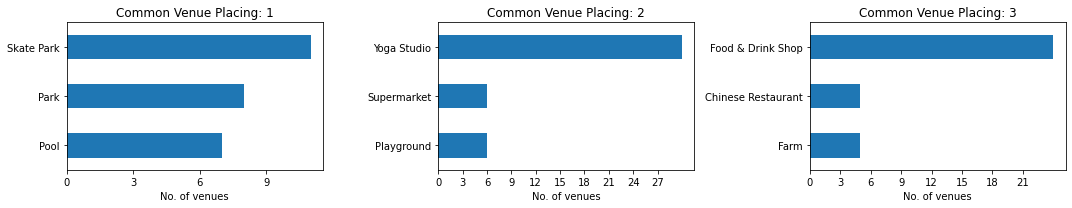

In [79]:
df_list = [first_common_1, second_common_1, third_common_1]
fig, axes = plt.subplots(1, 3)

count = 0
for r in range(3):
    df_list[count].value_counts(ascending=True).tail(3).plot.barh(ax = axes[r], width=0.5, figsize=(15,3))
    axes[r].set_title('Common Venue Placing: {}'.format(count+1))
    plt.sca(axes[r])
    plt.xticks(np.arange(0, df_list[r].value_counts().max(), 3))
    plt.xlabel('No. of venues')
    count += 1

fig.tight_layout()

#### Cluster 1: On average, costs $418,000 and is 99 sqm floor area

#### Additionally, 
1st Most Common Venues: Skate parks, parks, and pool <br>
2nd Most Common Venues: Yoga studios, supermarket, playground <br>
3rd Most Common Venues: F&B, farms

#### This cluster of flats seems to have more sports & recreational venues nearby. 

----

### Cluster 2

In [87]:
#Creating Series from 1st - 3rd Most Common Venues

cluster2 = hdb_merged.loc[hdb_merged['Cluster Labels'] == 1, hdb_merged.columns[[0,1,2,3,4,5,6,7,8]]]
first_common_2 = cluster2.iloc[:,2]
second_common_2 = cluster2.iloc[:,3]
third_common_2 = cluster2.iloc[:,4]

In [88]:
print(cluster2.describe())
cluster2.sort_values(by=['Resale Price', 'Floor Area'])

       Cluster Labels   Resale Price  Floor Area
count           171.0     171.000000  171.000000
mean              1.0  573557.467836  128.549708
std               0.0  116452.868010   17.951295
min               1.0  300000.000000   67.000000
25%               1.0  491500.000000  120.000000
50%               1.0  552000.000000  127.000000
75%               1.0  640000.000000  146.000000
max               1.0  915000.000000  156.000000


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Resale Price,Floor Area
386,1,549 BEDOK NTH AVE 1,Coffee Shop,Food Court,Bus Station,Supermarket,Fast Food Restaurant,300000.0,67.0
385,1,549 BEDOK NTH AVE 1,Coffee Shop,Food Court,Bus Station,Supermarket,Fast Food Restaurant,352000.0,82.0
139,1,341 TAMPINES ST 33,Bus Station,Art Gallery,Yoga Studio,Farm,Food,378000.0,109.0
142,1,341 TAMPINES ST 33,Bus Station,Art Gallery,Yoga Studio,Farm,Food,378000.0,109.0
145,1,341 TAMPINES ST 33,Bus Station,Art Gallery,Yoga Studio,Farm,Food,378000.0,109.0
140,1,341 TAMPINES ST 33,Bus Station,Art Gallery,Yoga Studio,Farm,Food,380000.0,111.0
143,1,341 TAMPINES ST 33,Bus Station,Art Gallery,Yoga Studio,Farm,Food,380000.0,111.0
146,1,341 TAMPINES ST 33,Bus Station,Art Gallery,Yoga Studio,Farm,Food,380000.0,111.0
138,1,341 TAMPINES ST 33,Bus Station,Art Gallery,Yoga Studio,Farm,Food,400000.0,107.0
141,1,341 TAMPINES ST 33,Bus Station,Art Gallery,Yoga Studio,Farm,Food,400000.0,107.0


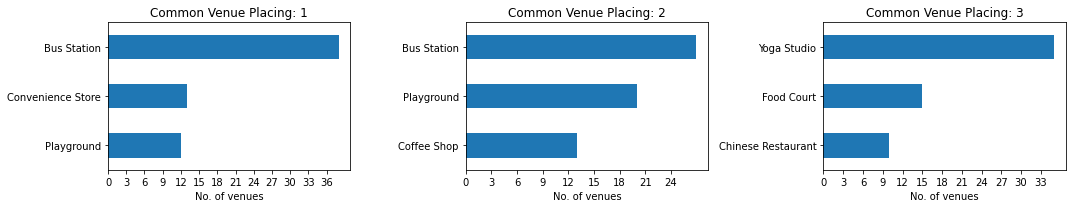

In [89]:
df_list = [first_common_2, second_common_2, third_common_2]
fig, axes = plt.subplots(1, 3)

count = 0
for r in range(3):
    df_list[count].value_counts(ascending=True).tail(3).plot.barh(ax = axes[r], width=0.5, figsize=(15,3))
    axes[r].set_title('Common Venue Placing: {}'.format(count+1))
    plt.sca(axes[r])
    plt.xticks(np.arange(0, df_list[r].value_counts().max(), 3))
    plt.xlabel('No. of venues')
    count += 1

fig.tight_layout()

#### Cluster 2: On average, costs $573,000 and is 128 sqm floor area

#### Additionally, 
1st Most Common Venues: Bus stations, playground, and convenience stores <br>
2nd Most Common Venues: Bus stations, playground, coffee shop <br>
3rd Most Common Venues: Yoga studios, food court, chinese food

#### This cluster of flats seems to offer good transportation options as well as food close by. 

----

### Cluster 3

In [90]:
#Creating Series from 1st - 3rd Most Common Venues
cluster3 = hdb_merged.loc[hdb_merged['Cluster Labels'] == 2, hdb_merged.columns[[0,1,2,3,4,5,6,7,8]]]
first_common_3 = cluster3.iloc[:,2]
second_common_3 = cluster3.iloc[:,3]
third_common_3 = cluster3.iloc[:,4]

In [91]:
print(cluster3.describe())
cluster3.sort_values(by=['Resale Price', 'Floor Area'])

       Cluster Labels   Resale Price  Floor Area
count           190.0     190.000000  190.000000
mean              2.0  313637.705263   73.105263
std               0.0   54950.550580   11.614144
min               2.0  240000.000000   59.000000
25%               2.0  280000.000000   67.000000
50%               2.0  300000.000000   68.000000
75%               2.0  340000.000000   82.000000
max               2.0  603000.000000  134.000000


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Resale Price,Floor Area
411,2,36 CHAI CHEE AVE,Seafood Restaurant,Yoga Studio,Food & Drink Shop,Dessert Shop,Diner,240000.0,65.0
413,2,36 CHAI CHEE AVE,Seafood Restaurant,Yoga Studio,Food & Drink Shop,Dessert Shop,Diner,240000.0,65.0
14,2,50 CHAI CHEE ST,Chinese Restaurant,Bus Station,Yoga Studio,Food,Flea Market,240000.0,68.0
16,2,50 CHAI CHEE ST,Chinese Restaurant,Bus Station,Yoga Studio,Food,Flea Market,240000.0,68.0
468,2,18 BEDOK STH RD,Chinese Restaurant,Noodle House,Bus Station,Food Court,Asian Restaurant,240500.0,65.0
147,2,527 BEDOK NTH ST 3,Bus Station,Asian Restaurant,Steakhouse,Yoga Studio,Fast Food Restaurant,250000.0,68.0
266,2,529 BEDOK NTH ST 3,Steakhouse,Bus Station,Coffee Shop,Yoga Studio,Farm,250000.0,68.0
271,2,529 BEDOK NTH ST 3,Steakhouse,Bus Station,Coffee Shop,Yoga Studio,Farm,250000.0,68.0
276,2,529 BEDOK NTH ST 3,Steakhouse,Bus Station,Coffee Shop,Yoga Studio,Farm,250000.0,68.0
281,2,529 BEDOK NTH ST 3,Steakhouse,Bus Station,Coffee Shop,Yoga Studio,Farm,250000.0,68.0


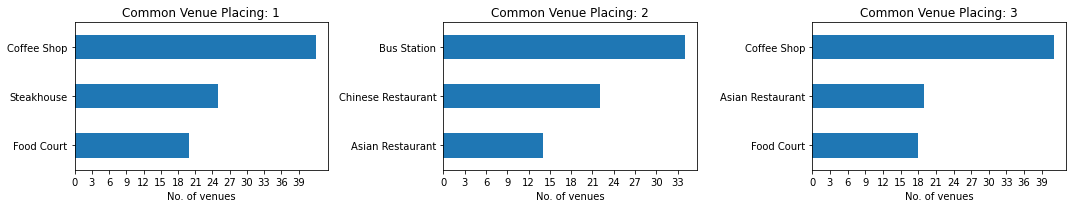

In [92]:
df_list = [first_common_3, second_common_3, third_common_3]
fig, axes = plt.subplots(1, 3)

count = 0
for r in range(3):
    df_list[count].value_counts(ascending=True).tail(3).plot.barh(ax = axes[r], width=0.5, figsize=(15,3))
    axes[r].set_title('Common Venue Placing: {}'.format(count+1))
    plt.sca(axes[r])
    plt.xticks(np.arange(0, df_list[r].value_counts().max(), 3))
    plt.xlabel('No. of venues')
    count += 1

fig.tight_layout()

#### Cluster 3: On average, costs $313,000 and is 73 sqm floor area 

#### Additionally, 
1st Most Common Venues: coffee shop, food court, and steakhouse <br>
2nd Most Common Venues: Bus stations, chinese food, asian food <br>
3rd Most Common Venues: coffee shop, asian food, food court

#### This cluster of flats has lots of food options close by. 

----

### Cluster 4

In [93]:
#Creating Series from 1st - 3rd Most Common Venues
cluster4 = hdb_merged.loc[hdb_merged['Cluster Labels'] == 3, hdb_merged.columns[[0,1,2,3,4,5,6,7,8]]]
first_common_4 = cluster4.iloc[:,2]
second_common_4 = cluster4.iloc[:,3]
third_common_4 = cluster4.iloc[:,4]

In [94]:
print(cluster4.describe())
cluster4.sort_values(by=['Resale Price', 'Floor Area'])

       Cluster Labels   Resale Price  Floor Area
count           117.0     117.000000  117.000000
mean              3.0  533238.145299   98.777778
std               0.0  115975.543921   18.163107
min               3.0  258000.000000   47.000000
25%               3.0  460000.000000   93.000000
50%               3.0  500000.000000   97.000000
75%               3.0  585000.000000  108.000000
max               3.0  838000.000000  145.000000


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Resale Price,Floor Area
556,3,528A PASIR RIS ST 51,Restaurant,Sandwich Place,Yoga Studio,Event Space,Flea Market,258000.0,47.0
153,3,890C TAMPINES AVE 1,Fast Food Restaurant,Coffee Shop,Food Court,Comfort Food Restaurant,Dessert Shop,345000.0,69.0
260,3,869A TAMPINES AVE 8,Plaza,Playground,Bus Station,Yoga Studio,Farm,360000.0,67.0
52,3,765 PASIR RIS ST 71,Playground,Asian Restaurant,Yoga Studio,Farm,Food,380000.0,104.0
56,3,522A TAMPINES CTRL 7,Playground,Bus Station,Trail,Yoga Studio,Farm,385000.0,67.0
487,3,527D PASIR RIS ST 51,Restaurant,Sandwich Place,Yoga Studio,Event Space,Flea Market,385000.0,68.0
175,3,890B TAMPINES AVE 1,Garden,Dessert Shop,Skate Park,Park,Yoga Studio,385000.0,69.0
232,3,417 PASIR RIS DR 6,Playground,Yoga Studio,Food & Drink Shop,Dessert Shop,Diner,405000.0,105.0
318,3,523B TAMPINES CTRL 7,Bubble Tea Shop,Trail,Bus Station,Noodle House,Food Court,408000.0,67.0
320,3,523B TAMPINES CTRL 7,Bubble Tea Shop,Trail,Bus Station,Noodle House,Food Court,408000.0,67.0


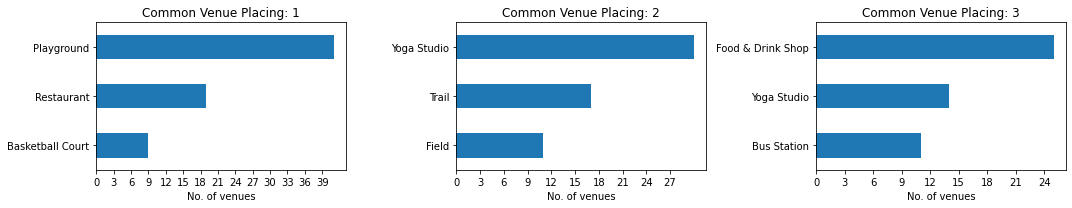

In [95]:
df_list = [first_common_4, second_common_4, third_common_4]
fig, axes = plt.subplots(1, 3)

count = 0
for r in range(3):
    df_list[count].value_counts(ascending=True).tail(3).plot.barh(ax = axes[r], width=0.5, figsize=(15,3))
    axes[r].set_title('Common Venue Placing: {}'.format(count+1))
    plt.sca(axes[r])
    plt.xticks(np.arange(0, df_list[r].value_counts().max(), 3))
    plt.xlabel('No. of venues')
    count += 1

fig.tight_layout()

#### Cluster 4: On average, costs $533,000 and is 98 sqm floor area

#### Additionally, 
1st Most Common Venues: playground, restaurant, and basketball <br>
2nd Most Common Venues: yoga studio, trail, field <br>
3rd Most Common Venues: F&B, yoga studio, bus station

#### This cluster of flats seems to be close to nature and has a good mixture of sports and recreational venues 

----

### Cluster 5

In [96]:
#Creating Series from 1st - 3rd Most Common Venues
cluster5 = hdb_merged.loc[hdb_merged['Cluster Labels'] == 4, hdb_merged.columns[[0,1,2,3,4,5,6,7,8]]]
first_common_5 = cluster5.iloc[:,2]
second_common_5 = cluster5.iloc[:,3]
third_common_5 = cluster5.iloc[:,4]

In [97]:
print(cluster5.describe())
cluster5.sort_values(by=['Resale Price', 'Floor Area'])

       Cluster Labels   Resale Price  Floor Area
count            65.0      65.000000   65.000000
mean              4.0  452381.169231  106.569231
std               0.0  100588.643528   23.075941
min               4.0  275000.000000   67.000000
25%               4.0  374000.000000   92.000000
50%               4.0  442000.000000  105.000000
75%               4.0  513000.000000  124.000000
max               4.0  750000.000000  157.000000


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Resale Price,Floor Area
546,4,264 TAMPINES ST 21,Coffee Shop,Yoga Studio,Food Court,Diner,Dog Run,275000.0,74.0
517,4,117 BEDOK RESERVOIR RD,Coffee Shop,Yoga Studio,Food Court,Diner,Dog Run,280000.0,67.0
620,4,122 BEDOK NTH ST 2,Coffee Shop,Convenience Store,Fishing Store,Yoga Studio,Farm,310000.0,67.0
570,4,521 BEDOK NTH AVE 1,Coffee Shop,Skate Park,Yoga Studio,Event Space,Flea Market,315000.0,82.0
337,4,237 TAMPINES ST 21,Restaurant,Basketball Court,Yoga Studio,Event Space,Flea Market,332000.0,73.0
610,4,275 TAMPINES ST 22,Coffee Shop,Australian Restaurant,Event Space,Food,Flea Market,335000.0,73.0
612,4,275 TAMPINES ST 22,Coffee Shop,Australian Restaurant,Event Space,Food,Flea Market,335000.0,73.0
390,4,283 TAMPINES ST 22,Coffee Shop,Playground,Gym,Yoga Studio,Event Space,342888.0,74.0
201,4,236 TAMPINES ST 21,Restaurant,Basketball Court,Yoga Studio,Event Space,Flea Market,350000.0,73.0
203,4,236 TAMPINES ST 21,Restaurant,Basketball Court,Yoga Studio,Event Space,Flea Market,350000.0,73.0


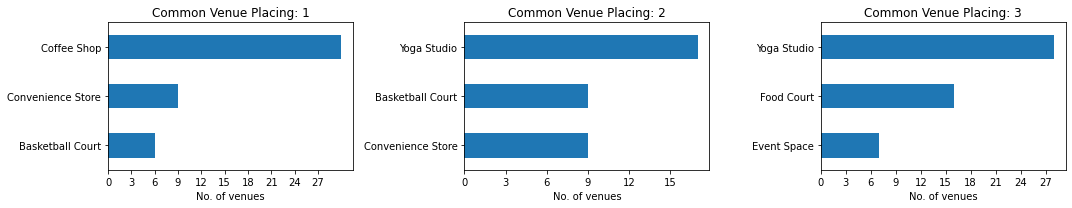

In [98]:
df_list = [first_common_5, second_common_5, third_common_5]
fig, axes = plt.subplots(1, 3)

count = 0
for r in range(3):
    df_list[count].value_counts(ascending=True).tail(3).plot.barh(ax = axes[r], width=0.5, figsize=(15,3))
    axes[r].set_title('Common Venue Placing: {}'.format(count+1))
    plt.sca(axes[r])
    plt.xticks(np.arange(0, df_list[r].value_counts().max(), 3))
    plt.xlabel('No. of venues')
    count += 1

fig.tight_layout()

#### Cluster 5: On average, costs $452,000 and is 106 sqm floor area

#### Additionally, 
1st Most Common Venues: coffee shop, convenience store, and basketball court <br>
2nd Most Common Venues: yoga studio, basketball court, convenience store <br>
3rd Most Common Venues: food court, yoga studio, event space

#### This cluster of flats seems to be close to event spaces and sports & recreational venues

----